Прочитать как скачать датасет с каггла - [тут](https://github.com/Kaggle/kaggle-api).

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""

In [8]:
!kaggle datasets download -d slothkong/10-monkey-species

 99%|████████████████████████████████████████▌| 542M/547M [00:04<00:00, 136MB/s]
100%|█████████████████████████████████████████| 547M/547M [00:04<00:00, 131MB/s]


In [9]:
import zipfile
with zipfile.ZipFile('10-monkey-species.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [7]:
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision
import torchvision.models as models
import pytorch_lightning as pl
import torch.nn as nn
from torchmetrics import Accuracy
import torch.optim as optim
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from collections import Counter
import torch.nn.functional as F

# Dataset

In [8]:
transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [10]:
train_ds = ImageFolder('./data/training/training/',transform=transforms)
test_ds = ImageFolder('./data/validation/validation/',transform=transforms)

In [11]:
train_cnt = Counter(train_ds.targets)
test_cnt = Counter(test_ds.targets)
print(train_cnt)
print(test_cnt)

Counter({3: 122, 7: 114, 5: 113, 1: 111, 2: 110, 6: 106, 8: 106, 0: 105, 4: 105, 9: 105})
Counter({3: 30, 1: 28, 5: 28, 7: 28, 2: 27, 8: 27, 0: 26, 4: 26, 6: 26, 9: 26})


# Dataloader

In [12]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True,num_workers=4)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False,num_workers=4)

# Model

In [80]:
class HWModel(pl.LightningModule):
    def __init__(self, num_classes, lr=2e-4):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.num_classes = num_classes
        self.model = models.resnet50(pretrained=True)
        in_feat = list(self.model.children())[-1].in_features
        self.model.fc = nn.Linear(in_feat, self.num_classes)

        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch

        preds = self(x)
        loss = self.loss_fn(preds, y)
        acc = self.accuracy(torch.argmax(preds, dim=1), y)

        self.log("train_loss", loss.item(), logger=True)
        self.log("train_acc", acc, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        preds = self(x)

        loss = self.loss_fn(preds, y)
        acc = self.accuracy(torch.argmax(preds, dim=1), y)

        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        acc = self.accuracy(torch.argmax(preds, dim=1), y)

        self.log("test_acc", acc, on_epoch=True, prog_bar=True)

# Train

In [81]:
from torch import Tensor
from typing import Type

In [88]:
model = HWModel(num_classes=10, lr=1e-3)
trainer_args = {
    "accelerator": "gpu",
    "max_epochs": 10,
    "log_every_n_steps" : 18,
}
trainer = pl.Trainer(**trainer_args)
trainer.fit(model, train_dl, test_dl)

/home/dimalkevich/miniconda3/envs/science/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dimalkevich/miniconda3/envs/science/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | model    | ResNet       

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/dimalkevich/miniconda3/envs/science/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [48]:
import pandas as pd

/tmp/ipykernel_4405/4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [86]:
data = pd.read_csv("./metrics.csv")

In [87]:
data

,epoch,step,train_acc,train_loss,val_acc,val_loss
0,0,17,0.111111,2.361852,NaN,NaN
1,0,17,NaN,NaN,0.246324,2.199854
2,1,35,0.333333,2.139010,NaN,NaN
3,1,35,NaN,NaN,0.470588,2.068194
4,2,53,0.777778,1.965901,NaN,NaN
5,2,53,NaN,NaN,0.632353,1.940076
6,3,71,0.666667,1.991740,NaN,NaN
7,3,71,NaN,NaN,0.816176,1.811844
8,4,89,0.777778,1.751424,NaN,NaN
9,4,89,NaN,NaN,0.889706,1.683845


In [65]:
n_d = data.drop(columns=['step', "train_acc_step", "train_loss_step"])

In [75]:
n_d

,epoch,train_acc_epoch,train_loss_epoch,val_acc,val_loss
0,0,NaN,NaN,0.375000,2.108259
1,0,0.229717,2.202598,NaN,NaN
2,1,NaN,NaN,0.547794,1.983595
3,1,0.435734,2.055550,NaN,NaN
4,2,NaN,NaN,NaN,NaN
5,2,NaN,NaN,0.709559,1.861345
6,2,0.638104,1.925843,NaN,NaN
7,3,NaN,NaN,0.808824,1.735252
8,3,0.760255,1.798209,NaN,NaN
9,4,NaN,NaN,0.863971,1.615430


In [77]:
t_a = n_d[['epoch', 'train_acc_epoch']].dropna()
t_l = n_d[['epoch', 'train_loss_epoch']].dropna()
v_l = n_d[['epoch', 'val_loss']].dropna()
v_a = n_d[['epoch', 'val_acc']].dropna()

In [72]:
t_a

,epoch,train_acc_epoch
1,0,0.229717
3,1,0.435734
6,2,0.638104
8,3,0.760255
10,4,0.837739
13,5,0.898815
15,6,0.940747
17,7,0.953510
20,8,0.967183
22,9,0.973564


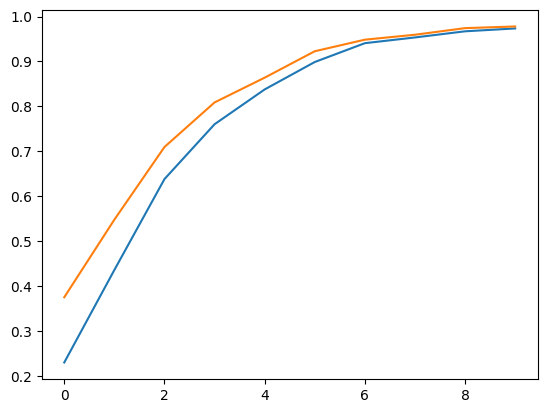

In [78]:
plt.plot(t_a.epoch, t_a.train_acc_epoch)
plt.plot(v_a.epoch, v_a.val_acc)
plt.show()

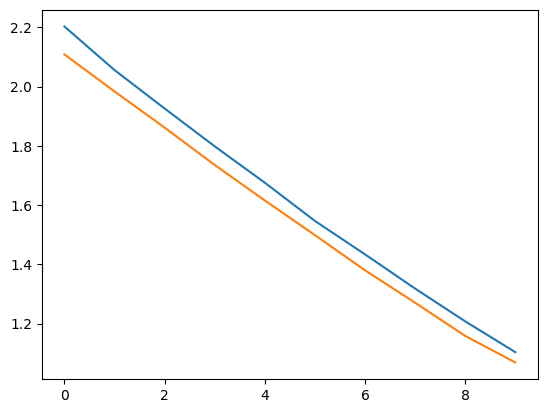

In [79]:
plt.plot(t_l.epoch, t_l.train_loss_epoch)
plt.plot(v_l.epoch, v_l.val_loss)
plt.show()

In [91]:
trainer.test_step()

AttributeError: 'Trainer' object has no attribute 'test_step'